# Global Precipitation Nowcasting of Integrated Multi-satellitE Retrievals for GPM: A U-Net Convolutional LSTM Architecture

This notebook uses the trained GENESIS models for global precipitation nowcastiong up to 4 hours. It contains following section:
1) Reading one full size input/output block. 

2) Creating patches with spatial size of 256*256 with 50% overlap and predictiong precipitation for each of them.

3) Reconstructing the entire domain by only considering interior 128*128 pixles.

4) Visualizing the global nowcasting results.

### Step 1) Reading the input/output in the original size

You can find all the used functions in the *utils.py* file.

In [1]:
# Loading the necessary packages

import os
import re
import numpy as np
from scipy import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from utils import *

2023-06-06 17:42:20.333605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Here we setting up GPU. It is not necessary step.
tf.config.optimizer.set_experimental_options({"layout_optimizer": False})

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Here we read one sample with spatial size of 1200*3600, that has three matrices in it including X(input), y(output), and GFS

current_directory = os.getcwd()
subfolder = "data"
path = os.path.join(current_directory, subfolder)
#path = "/panfs/jay/groups/0/ebtehaj/rahim035/paper_2/V2/github_nowcast/data"
mat_files = [
    f"{path}/{x}" for x in os.listdir(path)
    if re.match(r".*\.mat", x)
]


['/panfs/jay/groups/0/ebtehaj/rahim035/paper_2/V2/github_nowcast/data/sample_test_1.mat']

### Step 2) Creationg 256*256 patches

In [ ]:
# Here we create patches with spatila size 256*256 and 50% overlap to be fed to the network and save them in a seprate folder
patches = patchify_seq(mat_files, 256, 128, path)

In [4]:
# Here we load mean, and standard deviation for narmalizing the inputs, and class_weights to use for focal loss
subfolder = "GENESIS_models/"
path = os.path.join(current_directory, subfolder)
class_weights = np.load(path + "weight_10_1.npy", allow_pickle=True)
stat = io.loadmat(path + "stat_full_models.mat")
mean_x = stat["mean_x"]
std_x  = stat["std_x"]
std    = np.transpose(std_x)
mu     = np.transpose(mean_x)

# Here we load the trained models
#%% Loading the GENESIS_MSE model
save_name_genesis_mse = f"GENESIS_MSE"
load_path_genesis_mse = f"{path}/{save_name_genesis_mse}.h5"
genesis_mse = tf.keras.models.load_model(load_path_genesis_mse)

#%% Loading the GENESIS_Fl model and compiling it beacuse of the defined focal loss
save_name_genesis_fl = f"GENESIS_FL"
load_path_genesis_fl = f"{path}/{save_name_genesis_fl}.h5"
genesis_fl = tf.keras.models.load_model(load_path_genesis_fl, custom_objects={'CategoricalFocalLoss': CategoricalFocalLoss(alpha=class_weights, gamma=2)}, compile=False)
loss=[CategoricalFocalLoss(alpha=class_weights, gamma=2)]
genesis_fl.compile(
     loss=loss,
     optimizer=keras.optimizers.Adam(learning_rate=0.0001),
     metrics=[tf.keras.metrics.Recall()])


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A40, compute capability 8.6


2023-06-06 17:43:31.603380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 17:43:31.880358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43706 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:0b:00.0, compute capability: 8.6


### Step 3) Predicting precipitation field for each patch with 4-hour lead time and reconsturct the original field.

In [12]:
# Here we predict precipitation field for the next 4-hour for each patch

i = 0
bins_num = 9 
current_directory = os.getcwd()
subfolder = "data"
path = os.path.join(current_directory, subfolder)
directory = 'sample_'+str(i)
test_directory = os.path.join(path, directory) 
test_paths = [f"{test_directory}/{x}" for x in os.listdir(test_directory)]

# Prediction
## regression model
test_dataset_reg = CustomGenerator_reg(test_paths,  mu, std, 1, shuffle=False)
pred_genesis_mse = genesis_mse.predict(test_dataset_reg)
pred_genesis_mse = pow(10,pred_genesis_mse)

## classification model
test_dataset_class   = CustomGenerator_class(test_paths,  mu, std, 1, bins_num, shuffle=False)
pred_genesis_fl = genesis_fl.predict(test_dataset_class)
pred_genesis_fl = np.argmax(pred_genesis_fl,axis = -1)

# Loading the observed data
obs_mse = []
gfs_mse = []
obs_fl  = []
gfs_fl  = []

for k in range(252):
    X_mse, y_mse, g_mse = test_dataset_reg.__getitem__(k)
    y_mse = y_mse[0]
    g_mse = g_mse[0]
    y_mse = pow(10,y_mse)
    g_mse = pow(10,g_mse)
    obs_mse.append(y_mse)
    gfs_mse.append(g_mse)
    
    X_fl, y_fl, g_fl = test_dataset_class.__getitem__(k)
    y_fl = y_fl[0]
    g_fl = g_fl[0]
    y_fl = np.argmax(y_fl, axis = -1)
    g_fl = np.argmax(g_fl, axis = -1)
    obs_fl.append(y_fl)
    gfs_fl.append(g_fl)
    
obs_mse = np.array(obs_mse)
gfs_mse = np.array(gfs_mse)
obs_fl  = np.array(obs_fl)
gfs_fl  = np.array(gfs_fl)

# Here we merge the predicted patches to reconstruc the orginal spatial domain by only considering 128*128 interior pixels.

observation_mse = merge_patches_v2(obs_mse, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])
GFS_mse         = merge_patches_v2(gfs_mse, [256,256], 0.5, 64, [128,128], [4,1280,3712], [4,1200,3600])
prediction_mse  = merge_patches_v2(pred_genesis_mse, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])

observation_fl  = merge_patches_v2(obs_fl, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])
GFS_fl          = merge_patches_v2(gfs_fl, [256,256], 0.5, 64, [128,128], [4,1280,3712], [4,1200,3600])
prediction_fl   = merge_patches_v2(pred_genesis_fl, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])


bins = np.linspace(np.log10(0.101), np.log10(32), bins_num)

observation_mse[observation_mse<0.1] = 0.1
observation_mse = np.log10(observation_mse)
observation_mse = np.digitize(observation_mse, bins)   # classes ranges from 0 to bin_num

prediction_mse[prediction_mse<0.1] = 0.1
prediction_mse = np.log10(prediction_mse)
prediction_mse = np.digitize(prediction_mse, bins)   # classes ranges from 0 to bin_num


252/252 [==============================] - 22s 86ms/step


### Step 4) Visualizing the results

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

In [10]:
# load the coordination
coord = io.loadmat(path + "/coordination.mat")
lat = coord['lat']
lon = coord['lon']

# load the colormap
cmap = io.loadmat(path + "/colormap.mat")
cmap = cmap["Cmap_rain"]
newcmp = ListedColormap(cmap)

/tmp/ipykernel_2080407/468397628.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311,projection = ccrs.Mercator())
/tmp/ipykernel_2080407/468397628.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(['0.1','0.2','0.4','0.8','1.6','3.8','7.6','16'])


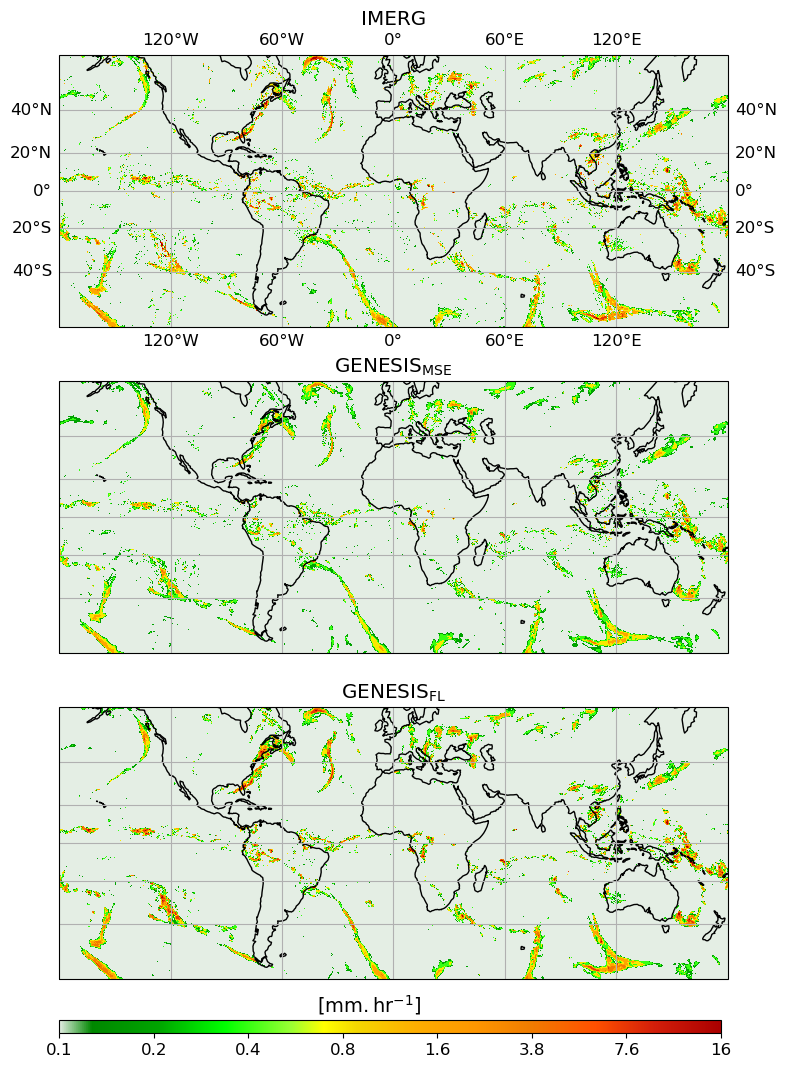

In [11]:
plt.rcParams['font.size'] = 12

fig = plt.subplots(figsize=(12, 12))

ax1 = plt.subplot(311,projection = ccrs.Mercator())
plot1 = plt. pcolormesh(lon, lat, np.squeeze(observation_mse[0,:,:]), vmin =1, vmax = 8, cmap = newcmp, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels = True)
ax1.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
ax1.set(title = 'IMERG')

ax2 = plt.subplot(312,projection = ccrs.Mercator())
plot2 = plt. pcolormesh(lon, lat, np.squeeze(prediction_mse[0,:,:]), vmin = 1, vmax = 8, cmap = newcmp, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels = False)
ax2.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
ax2.set(title = r'$\rm GENESIS_{MSE}$')

ax3 = plt.subplot(313,projection = ccrs.Mercator())
plot3 = plt. pcolormesh(lon, lat, np.squeeze(prediction_fl[0,:,:]), vmin = 1, vmax = 8, cmap = newcmp, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.gridlines(draw_labels = False)
ax3.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
cax   = ax3.inset_axes([0, -0.2, 0.99, 0.05])
cbar2 = plt.colorbar(plot3,ax = [ax3],cax = cax, orientation="horizontal")
ticks = np.arange(1,9,1)
cbar2.set_ticklabels(['0.1','0.2','0.4','0.8','1.6','3.8','7.6','16'])
ax3.text(-41, -67, '$\mathrm{[mm.hr^{-1}]}$', fontsize=14, transform=ccrs.PlateCarree())
ax3.set(title = r'$\rm GENESIS_{FL}$')

plt.show()
